> ### House Prices Prediction – EDA
>
>Performed by: 
>
>Zahra Eshtiaghi 476679
>
>Tsoi Kwan Ma 476914
>
>**Under Supervision of Professor Paweł Sakowski**
>
>Introduction 
>
> This notebook focuses on building a regression pipeline to predict house sale prices using the **Ames Housing dataset** from the Kaggle competition *House Prices: Advanced Regression Techniques*.
>
> The objective of this notebook is to perform **systematic data preprocessing and feature preparation** prior to model training. We begin with exploratory analysis to understand the structure of the dataset, identify missing values, and analyze feature distributions. Special attention is given to handling **skewed numerical features** and **categorical variables**, as these are common challenges in real-world tabular data.
>
> The preprocessing pipeline includes:
>
> * Separation of features and target variable
> * Train–validation split
> * Identification of numerical and categorical features
> * Missing value handling
> * Log transformation of skewed numerical variables
> * Feature encoding 
>
> The processed datasets are then saved to disk to ensure **reproducibility and modularity**.


 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



## Data Loading

In this section, we load the training and test datasets and perform an initial inspection to understand their structure. This step ensures that the data has been imported correctly and allows us to identify the number of observations and features available for modeling.


In [2]:
df_test = pd.read_csv('data/test.csv')
df = pd.read_csv('data/train.csv')  # Replace with the correct filename

# Show basic info
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   20

##  Initial Data Exploration

We explore the dataset by examining data types, summary statistics, and missing values. This analysis helps identify potential data quality issues and guides the selection of appropriate preprocessing techniques for numerical and categorical features.


In [3]:
# the structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# 1. Separate features and target
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

## Train–Validation Split

To evaluate model performance reliably, the dataset is split into training and validation sets. This ensures that model evaluation is performed on unseen data and reduces the risk of overfitting during training.


In [5]:
# 2. Split into train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df_test.copy()


In [6]:
# Verify shapes
print(f"Training set: {X_train.shape}, val set: {X_val.shape}")

Training set: (1168, 80), val set: (292, 80)


In [7]:

columns_with_missings = X_train.columns[X_train.isnull().any()]

# Print missing value counts
print("Missing value counts:\n")
print(X_train[columns_with_missings].isnull().sum())

Missing value counts:

LotFrontage      217
Alley           1094
MasVnrType       683
MasVnrArea         6
BsmtQual          28
BsmtCond          28
BsmtExposure      28
BsmtFinType1      28
BsmtFinType2      28
Electrical         1
FireplaceQu      547
GarageType        64
GarageYrBlt       64
GarageFinish      64
GarageQual        64
GarageCond        64
PoolQC          1162
Fence            935
MiscFeature     1122
dtype: int64


In [8]:
# Print frequency tables for each column
print("\nFrequency counts for columns with missing values:\n")
for column in columns_with_missings:
    print(f"\nFrequency counts for {column}:")
    print(X_train[column].value_counts(dropna=False))
    print("-" * 50)  # Add separator between columns


Frequency counts for columns with missing values:


Frequency counts for LotFrontage:
LotFrontage
NaN      217
60.0     112
70.0      57
80.0      54
50.0      47
        ... 
106.0      1
168.0      1
141.0      1
144.0      1
153.0      1
Name: count, Length: 108, dtype: int64
--------------------------------------------------

Frequency counts for Alley:
Alley
NaN     1094
Grvl      44
Pave      30
Name: count, dtype: int64
--------------------------------------------------

Frequency counts for MasVnrType:
MasVnrType
NaN        683
BrkFace    366
Stone      106
BrkCmn      13
Name: count, dtype: int64
--------------------------------------------------

Frequency counts for MasVnrArea:
MasVnrArea
0.0      674
108.0      7
180.0      7
NaN        6
106.0      6
        ... 
254.0      1
860.0      1
128.0      1
796.0      1
309.0      1
Name: count, Length: 287, dtype: int64
--------------------------------------------------

Frequency counts for BsmtQual:
BsmtQual
TA     521
Gd   

## **Missing Value Handling Summary:**

1. **Alley, MasVnrType, BsmtQual, etc. (13 columns)** - `NaN` means feature doesn't exist → Fill with "None" (categorical placeholder).

2. **GarageYrBlt** - Missing garage year → Fill with most common year from training data (mode).

3. **MasVnrArea** - No masonry veneer → Fill with 0 square feet.

4. **LotFrontage** - Unknown street frontage → Fill with median of same neighborhood (houses nearby have similar lots).

5. **Electrical** - One missing electrical system → Fill with most common type (mode).

6. **PoolQC** - No pool → Fill with "No" (adds as new quality level).

7. **MiscFeature** - No miscellaneous feature → Fill with "None".

**Logic:** Preserve information where `NaN` has meaning ("doesn't exist"), use data patterns (neighborhood medians) where sensible, and fall back to common values (mode/median) for true unknowns.

In [9]:
# For columns where NaN means "None" (categorical)
none_cols = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 
             'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']

X_train[none_cols] = X_train[none_cols].fillna('None')
X_val[none_cols] = X_val[none_cols].fillna("None")
X_test[none_cols] = X_test[none_cols].fillna('None')

In [10]:
garage_mode = X_train['GarageYrBlt'].mode()[0]
X_train['GarageYrBlt'] = X_train['GarageYrBlt'].fillna(garage_mode)
X_val['GarageYrBlt'] = X_val['GarageYrBlt'].fillna(garage_mode)
X_test['GarageYrBlt'] = X_test['GarageYrBlt'].fillna(garage_mode)

In [11]:
# For MasVnrArea: NaN likely means no veneer. Fill with 0

X_train['MasVnrArea'] = X_train['MasVnrArea'].fillna(0)
X_val['MasVnrArea'] = X_val['MasVnrArea'].fillna(0)
X_test['MasVnrArea'] = X_test['MasVnrArea'].fillna(0)

This imputes missing **LotFrontage** values with the median LotFrontage of the same neighborhood.

Why by neighborhood?
Houses in the same neighborhood tend to have similar lot characteristics. This is more accurate than using the overall median

In [12]:
# LotFrontage (median by neighborhood from TRAINING only)
lot_median_by_neigh = X_train.groupby('Neighborhood')['LotFrontage'].median()
X_train['LotFrontage'] = X_train.apply(
    lambda row: lot_median_by_neigh[row['Neighborhood']] if pd.isna(row['LotFrontage']) else row['LotFrontage'], 
    axis=1
)
X_val['LotFrontage'] = X_val.apply(
    lambda row: lot_median_by_neigh.get(row['Neighborhood'], lot_median_by_neigh.median()) if pd.isna(row['LotFrontage']) else row['LotFrontage'], 
    axis=1
)
X_test['LotFrontage'] = X_test.apply(
    lambda row: lot_median_by_neigh.get(row['Neighborhood'], lot_median_by_neigh.median()) if pd.isna(row['LotFrontage']) else row['LotFrontage'], 
    axis=1
)

In [13]:
# Electrical (mode)
elec_mode = X_train['Electrical'].mode()[0]
X_train['Electrical'] = X_train['Electrical'].fillna(elec_mode)
X_val['Electrical'] = X_val['Electrical'].fillna(elec_mode)
X_test['Electrical'] = X_test['Electrical'].fillna(elec_mode)

In [14]:
# PoolQC: NaN = No Pool
X_train['PoolQC'] = X_train['PoolQC'].fillna('No')
X_val['PoolQC'] = X_val['PoolQC'].fillna('No')
X_test['PoolQC'] = X_test['PoolQC'].fillna('No')

In [15]:
# MiscFeature: NaN =  None
X_train['MiscFeature'] = X_train['MiscFeature'].fillna('None')
X_val['MiscFeature'] = X_val['MiscFeature'].fillna('None')
X_test['MiscFeature'] = X_test['MiscFeature'].fillna('None')

In [16]:
test_columns_with_missings = X_test.columns[X_test.isnull().any()]

# Print missing value counts
print("Missing value counts:\n")
print(X_test[columns_with_missings].isnull().sum())

Missing value counts:

LotFrontage     0
Alley           0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64


In [17]:
# Print frequency tables for each column
print("\nFrequency counts for columns with missing values after imputation:\n")
for column in columns_with_missings:
    print(f"\nFrequency counts for {column}:")
    print(X_train[column].value_counts(dropna=False))
    print("-" * 50)  # Add separator between columns


Frequency counts for columns with missing values after imputation:


Frequency counts for LotFrontage:
LotFrontage
60.0     120
80.0      91
70.0      76
65.0      60
50.0      47
        ... 
144.0      1
128.0      1
39.0       1
141.0      1
153.0      1
Name: count, Length: 114, dtype: int64
--------------------------------------------------

Frequency counts for Alley:
Alley
None    1094
Grvl      44
Pave      30
Name: count, dtype: int64
--------------------------------------------------

Frequency counts for MasVnrType:
MasVnrType
None       683
BrkFace    366
Stone      106
BrkCmn      13
Name: count, dtype: int64
--------------------------------------------------

Frequency counts for MasVnrArea:
MasVnrArea
0.0      680
108.0      7
180.0      7
200.0      6
106.0      6
        ... 
366.0      1
576.0      1
768.0      1
378.0      1
309.0      1
Name: count, Length: 286, dtype: int64
--------------------------------------------------

Frequency counts for BsmtQual:
BsmtQual

In [18]:
# Verify imputation by checking for remaining NaN values
print("NaN counts after imputation:")
# Verify
print("Missing in X_train:", X_train.isnull().sum().sum())
print("Missing in X_val:", X_val.isnull().sum().sum())
print("Missing in X_test:", X_test.isnull().sum().sum())

NaN counts after imputation:
Missing in X_train: 0
Missing in X_val: 0
Missing in X_test: 22


In [19]:
test_columns_with_missings = X_test.columns[X_test.isnull().any()]

# Print missing value counts
print("Missing value counts:\n")
print(X_test[test_columns_with_missings].isnull().sum())

Missing value counts:

MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
GarageCars      1
GarageArea      1
SaleType        1
dtype: int64


#### The test set cannot have missing values for prediction.
- For categorical: Use training mode
- For basement/garage numerical: If corresponding quality is "None", fill with 0
- This maintains data consistency

In [20]:
# Categorical columns - fill with mode from TRAINING
cat_cols = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 
            'KitchenQual', 'Functional', 'SaleType']

for col in cat_cols:
    mode_val = X_train[col].mode()[0]
    X_test[col] = X_test[col].fillna(mode_val)

# Numerical basement columns - if basement features missing, likely no basement
# Check if corresponding BsmtQual is 'None'
bsmt_num_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                 'BsmtFullBath', 'BsmtHalfBath']

for col in bsmt_num_cols:
    # If basement quality is 'None', fill with 0
    mask = (X_test['BsmtQual'] == 'None') & (X_test[col].isna())
    X_test.loc[mask, col] = 0
    
    # For any remaining NaN (shouldn't happen), fill with 0
    X_test[col] = X_test[col].fillna(0)

# Garage columns - similar logic
garage_num_cols = ['GarageCars', 'GarageArea']

for col in garage_num_cols:
    # If garage type is 'None', fill with 0
    mask = (X_test['GarageType'] == 'None') & (X_test[col].isna())
    X_test.loc[mask, col] = 0
    
    # For any remaining NaN, fill with 0
    X_test[col] = X_test[col].fillna(0)

# Verify no missing values remain
print("Remaining missing in X_test:", X_test.isnull().sum().sum())

Remaining missing in X_test: 0


## Feature Type Identification

Features are divided into **numerical** and **categorical** groups. This separation allows us to apply appropriate preprocessing techniques to each feature type, such as imputation and scaling for numerical variables and encoding for categorical variables.

In [21]:
# Lets check the frequencies of individual levels of all the nominal variables

# Based on the information about the dataset we can list all nominal variables
nominal_variables = [
    'MSSubClass',    # Dwelling type - categories not ordered
    'MSZoning',      # Zoning classification
    'Street',        # Road type
    'Alley',         # Alley type
    'LotShape',      # Shape categories not ordered
    'LandContour',   # Flatness types
    'Utilities',     # Utility types
    'LotConfig',     # Lot configuration
    'LandSlope',     # Slope categories
    'Neighborhood',  # Location names
    'Condition1',    # Proximity conditions
    'Condition2',    # Secondary conditions
    'BldgType',      # Dwelling type
    'HouseStyle',    # Style categories not ordered
    'RoofStyle',     # Roof types
    'RoofMatl',      # Roof materials
    'Exterior1st',   # Exterior covering
    'Exterior2nd',   # Secondary exterior
    'MasVnrType',    # Masonry type
    'Foundation',    # Foundation type
    'Heating',       # Heating type
    'Electrical',    # Electrical system
    'Functional',    # Functionality categories
    'GarageType',    # Garage location types
    'GarageFinish',  # Finish categories (could be ordinal but treat as nominal)
    'PavedDrive',    # Driveway type
    'MiscFeature',   # Miscellaneous features
    'SaleType',      # Sale type
    'SaleCondition'  # Sale condition
]

In [22]:
# Loop through each nominal variable
for var in nominal_variables:
    print(f"\n{var}:")
    print(X_train[var].value_counts(dropna=False))
    print("-" * 50)


MSSubClass:
MSSubClass
20     434
60     240
50     113
120     64
70      52
30      50
160     49
80      45
90      41
190     28
85      17
75      15
45      10
180      7
40       3
Name: count, dtype: int64
--------------------------------------------------

MSZoning:
MSZoning
RL         924
RM         172
FV          53
RH          15
C (all)      4
Name: count, dtype: int64
--------------------------------------------------

Street:
Street
Pave    1164
Grvl       4
Name: count, dtype: int64
--------------------------------------------------

Alley:
Alley
None    1094
Grvl      44
Pave      30
Name: count, dtype: int64
--------------------------------------------------

LotShape:
LotShape
Reg    729
IR1    394
IR2     37
IR3      8
Name: count, dtype: int64
--------------------------------------------------

LandContour:
LandContour
Lvl    1059
Bnk      48
HLS      35
Low      26
Name: count, dtype: int64
--------------------------------------------------

Utilities:
Utilities

In [23]:
# Threshold: categories with less than 1% of data (approx 11 houses)
threshold = 0.01 * len(X_train)

    # Columns to NOT group (keep all categories)
do_not_group = ['Street', 'Utilities', 'Condition2']  # Add others as needed

for var in nominal_variables:
    if var in do_not_group:
        continue  # Skip grouping for these
        
    value_counts = X_train[var].value_counts()
    
    if 'None' in value_counts.index:
        continue
        
    rare_categories = value_counts[value_counts < threshold].index
    
    if len(rare_categories) > 0:
        X_train[var] = X_train[var].replace(rare_categories, 'Other')
        X_val[var] = X_val[var].replace(rare_categories, 'Other')
        X_test[var] = X_test[var].replace(rare_categories, 'Other')

    print(f"{var}: Grouped {len(rare_categories)} rare categories")

MSSubClass: Grouped 3 rare categories
MSZoning: Grouped 1 rare categories
LotShape: Grouped 1 rare categories
LandContour: Grouped 0 rare categories
LotConfig: Grouped 1 rare categories
LandSlope: Grouped 1 rare categories
Neighborhood: Grouped 4 rare categories
Condition1: Grouped 4 rare categories
BldgType: Grouped 0 rare categories
HouseStyle: Grouped 2 rare categories
RoofStyle: Grouped 4 rare categories
RoofMatl: Grouped 6 rare categories
Exterior1st: Grouped 5 rare categories
Exterior2nd: Grouped 6 rare categories
Foundation: Grouped 2 rare categories
Heating: Grouped 4 rare categories
Electrical: Grouped 1 rare categories
Functional: Grouped 3 rare categories
PavedDrive: Grouped 0 rare categories
SaleType: Grouped 6 rare categories
SaleCondition: Grouped 2 rare categories


In [24]:
# Check what was grouped for key columns
important_cols = ['MSZoning', 'Neighborhood', 'Exterior1st', 'Exterior2nd', 'SaleType']

for var in important_cols:
    print(f"\n{var} categories after grouping:")
    print(X_train[var].value_counts())
    print("-" * 50)


MSZoning categories after grouping:
MSZoning
RL       924
RM       172
FV        53
RH        15
Other      4
Name: count, dtype: int64
--------------------------------------------------

Neighborhood categories after grouping:
Neighborhood
NAmes      181
CollgCr    115
OldTown     91
Edwards     87
Somerst     69
NWAmes      66
Gilbert     65
NridgHt     61
Sawyer      58
BrkSide     45
Crawfor     44
SawyerW     44
Mitchel     40
NoRidge     33
Timber      28
Other       27
IDOTRR      26
SWISU       21
StoneBr     20
ClearCr     19
Blmngtn     15
BrDale      13
Name: count, dtype: int64
--------------------------------------------------

Exterior1st categories after grouping:
Exterior1st
VinylSd    420
HdBoard    176
MetalSd    173
Wd Sdng    171
Plywood     81
CemntBd     45
BrkFace     40
Stucco      21
WdShing     19
AsbShng     16
Other        6
Name: count, dtype: int64
--------------------------------------------------

Exterior2nd categories after grouping:
Exterior2nd
Vinyl

The test/val sets might have new categories not seen in training.

lets Check for unseen categories:

In [25]:
# After grouping, check for categories in test/val that don't exist in training
for var in nominal_variables:
    train_cats = set(X_train[var].unique())
    val_cats = set(X_val[var].unique())
    test_cats = set(X_test[var].unique())
    
    # Find categories in val/test but not in training
    val_unseen = val_cats - train_cats
    test_unseen = test_cats - train_cats
    
    if val_unseen:
        print(f"{var}: Unseen in val - {val_unseen}")
        # Replace unseen with 'Other' or most common
        X_val.loc[X_val[var].isin(val_unseen), var] = 'Other'
    
    if test_unseen:
        print(f"{var}: Unseen in test - {test_unseen}")
        X_test.loc[X_test[var].isin(test_unseen), var] = 'Other'

MSSubClass: Unseen in test - {150}
RoofMatl: Unseen in val - {'Membran'}
Electrical: Unseen in val - {'Mix'}


These are new categories in test/validation that don't exist in training:

In [26]:
# For MSSubClass: 150 is "1-1/2 STORY PUD - ALL AGES"
# Since it's unseen, map it to the most similar category or 'Other'
# Check what's most common PUD type in training
pud_classes = [120, 150, 160, 180]  # All PUD types
common_pud = X_train[X_train['MSSubClass'].isin(pud_classes)]['MSSubClass'].mode()
if len(common_pud) > 0:
    replacement = common_pud[0]  # Most common PUD type
else:
    replacement = 'Other'  # Fallback

X_test.loc[X_test['MSSubClass'] == 150, 'MSSubClass'] = replacement

# For RoofMatl: 'Membran' is membrane roofing
# Since extremely rare, map to 'Other' (already grouped other rare types)
X_val.loc[X_val['RoofMatl'] == 'Membran', 'RoofMatl'] = 'Other'

# For Electrical: 'Mix' is mixed system  
# Map to most common electrical type
elec_mode = X_train['Electrical'].mode()[0]
X_val.loc[X_val['Electrical'] == 'Mix', 'Electrical'] = elec_mode



In [27]:
# Verify all categories now match
for var in ['MSSubClass', 'RoofMatl', 'Electrical']:
    train_cats = set(X_train[var].unique())
    val_cats = set(X_val[var].unique())
    test_cats = set(X_test[var].unique())
    
    print(f"\n{var}:")
    print(f"Train: {len(train_cats)} categories")
    print(f"Val: {len(val_cats)} categories, matches: {val_cats.issubset(train_cats)}")
    print(f"Test: {len(test_cats)} categories, matches: {test_cats.issubset(train_cats)}")


MSSubClass:
Train: 13 categories
Val: 13 categories, matches: True
Test: 13 categories, matches: True

RoofMatl:
Train: 2 categories
Val: 2 categories, matches: True
Test: 2 categories, matches: True

Electrical:
Train: 4 categories
Val: 4 categories, matches: True
Test: 4 categories, matches: True


# Near-zero variance

In [28]:
# lets define a function checking near-zero variance
def near_zero_var(df, freq_cut=95/5, unique_cut=10):
    """
    Identifies columns with near-zero variance in a DataFrame and calculates indicators.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - freq_cut (float): Threshold for the frequency ratio (default = 95/5).
    - unique_cut (int): Threshold for the unique value ratio (default = 10).

    Returns:
    - pd.DataFrame: A sorted DataFrame containing:
        - variable: Column name
        - freq_ratio: Ratio of the most common value to the second most common value
        - unique_ratio: Ratio of unique values to total observations
        - high_freq_ratio: Binary indicator (1 if freq_ratio > freq_cut)
        - low_unique_ratio: Binary indicator (1 if unique_ratio < unique_cut)
    """
    results = []

    for col in df.columns:
        # Get the value counts
        counts = df[col].value_counts()

        # Calculate freq_ratio
        if len(counts) > 1:
            freq_ratio = counts.iloc[0] / counts.iloc[1]
        else:
            freq_ratio = float('inf')  # Only one unique value

        # Calculate unique_ratio
        unique_ratio = len(counts) / len(df)

        # Determine binary indicators
        high_freq_ratio = int(freq_ratio > freq_cut)
        low_unique_ratio = int(unique_ratio < unique_cut)

        # Append results
        results.append({
            'variable': col,
            'freq_ratio': freq_ratio,
            'unique_ratio': unique_ratio,
            'high_freq_ratio': high_freq_ratio,
            'low_unique_ratio': low_unique_ratio
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Sort by 'high_freq_ratio' (descending) and 'low_unique_ratio' (ascending)
    results_df = results_df.sort_values(by=['freq_ratio', 'unique_ratio'], ascending=[False, True])

    return results_df


In [29]:
# Apply to X_train (training features after preprocessing)
nzv_df = near_zero_var(X_train, freq_cut=95/5, unique_cut=10)

# Get near-zero variance columns
nzv_columns = nzv_df[(nzv_df['low_unique_ratio'] == 1) & 
                     (nzv_df['high_freq_ratio'] == 1)]['variable'].tolist()

print(f"Near-zero variance columns: {nzv_columns}")
print(f"Count: {len(nzv_columns)}")

Near-zero variance columns: ['Utilities', 'PoolArea', 'PoolQC', '3SsnPorch', 'Condition2', 'LowQualFinSF', 'Street', 'BsmtFinSF2', 'ScreenPorch', 'MiscVal', 'MasVnrArea', '2ndFlrSF', 'EnclosedPorch', 'Heating', 'RoofMatl', 'Functional', 'BsmtFinSF1', 'MiscFeature', 'Alley', 'LandContour', 'BsmtFinType2', 'LandSlope', 'OpenPorchSF', 'WoodDeckSF', 'KitchenAbvGr']
Count: 25


In [30]:
# For each nzv column, check if it has ANY predictive power
nzv_to_keep = []
for col in nzv_columns:
    if col in X_train.columns:  # Ensure column exists
        # Simple check: mean target by category
        if X_train[col].nunique() > 1:  # Has variation
            temp_df = pd.DataFrame({'feature': X_train[col], 'target': y_train})
            group_means = temp_df.groupby('feature')['target'].mean()
            # If categories have different mean prices, keep
            if group_means.std() > y_train.std() * 0.05:  # 5% of overall variation
                nzv_to_keep.append(col)
                print(f"Keep {col}: price variation = {group_means.std():.0f}")

# Drop only truly useless columns
cols_to_drop = [col for col in nzv_columns if col not in nzv_to_keep]
print(f"\nDropping: {cols_to_drop}")

X_train = X_train.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

Keep Utilities: price variation = 31098
Keep PoolArea: price variation = 205176
Keep PoolQC: price variation = 143696
Keep 3SsnPorch: price variation = 77937
Keep Condition2: price variation = 80240
Keep LowQualFinSF: price variation = 83969
Keep Street: price variation = 14477
Keep BsmtFinSF2: price variation = 53812
Keep ScreenPorch: price variation = 77219
Keep MiscVal: price variation = 51678
Keep MasVnrArea: price variation = 83432
Keep 2ndFlrSF: price variation = 86202
Keep EnclosedPorch: price variation = 53678
Keep Heating: price variation = 50462
Keep RoofMatl: price variation = 28206
Keep Functional: price variation = 19791
Keep BsmtFinSF1: price variation = 81784
Keep MiscFeature: price variation = 55742
Keep Alley: price variation = 31040
Keep LandContour: price variation = 42719
Keep BsmtFinType2: price variation = 34148
Keep LandSlope: price variation = 22690
Keep OpenPorchSF: price variation = 65857
Keep WoodDeckSF: price variation = 84806
Keep KitchenAbvGr: price variat


**Summary:**
Some features look “rare” or low-variance (e.g., `PoolQC`, `Street`, `Utilities`, `Condition2`), but they show **large price differences** across categories. This means they carry **strong predictive signal** despite low frequency.

**Key Point:**
Low variance ≠ low importance. Even uncommon categories can influence price significantly (e.g., houses with pools are much more expensive; gravel streets are cheaper).

**Conclusion:**
**I should not drop these features.** They are rare but informative.

**Next Step – Encoding:**

* **Binary features:** simple 0/1 encoding
* **Numeric counts:** keep as continuous values
* **Ordinal categories:** label encode
* **Nominal categories:** one-hot encode (rare levels → “Other”)


## One Hot Encoding

In [31]:
# 1. BINARY FEATURES (2 categories)
binary_cols = []
for col in X_train.columns:
    if X_train[col].nunique() == 2:
        binary_cols.append(col)

print(f"Binary columns: {binary_cols}")

Binary columns: ['Street', 'Utilities', 'RoofMatl', 'CentralAir']


In [32]:
# Encode binary (0/1)
for col in binary_cols:
    # Get the two categories
    categories = X_train[col].unique()
    if len(categories) == 2:
        # Map to 0 and 1 (alphabetical order)
        mapping = {categories[0]: 0, categories[1]: 1}
        X_train[col] = X_train[col].map(mapping)
        X_val[col] = X_val[col].map(mapping)
        X_test[col] = X_test[col].map(mapping)

In [33]:
# 2. ORDINAL CATEGORICAL (inherent order)
ordinal_mappings = {
    'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'PoolQC': {'No': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'Fence': {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4},
    'Functional': {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}
}

In [34]:
# Apply ordinal encoding
for col, mapping in ordinal_mappings.items():
    if col in X_train.columns:
        X_train[col] = X_train[col].map(mapping)
        X_val[col] = X_val[col].map(mapping)
        X_test[col] = X_test[col].map(mapping)

In [35]:
# Explicit nominal columns (based on your dataset description)
explicit_nominal = [
    'MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType',
    'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType',
    'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition'
]

# Filter to only those that exist in data
nominal_cols = [col for col in explicit_nominal if col in X_train.columns]

print(f"One-hot encoding {len(nominal_cols)} nominal columns")

One-hot encoding 24 nominal columns


In [36]:
# NOMINAL CATEGORICAL (one-hot encode)
# Convert all nominal columns to string type
for col in nominal_cols:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Now one-hot encode
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[nominal_cols])

# Transform
train_encoded = encoder.transform(X_train[nominal_cols])
val_encoded = encoder.transform(X_val[nominal_cols])
test_encoded = encoder.transform(X_test[nominal_cols])

# Create DataFrames
encoded_cols = encoder.get_feature_names_out(nominal_cols)
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_cols, index=X_train.index)
val_encoded_df = pd.DataFrame(val_encoded, columns=encoded_cols, index=X_val.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=X_test.index)

# Combine
X_train = pd.concat([X_train.drop(columns=nominal_cols), train_encoded_df], axis=1)
X_val = pd.concat([X_val.drop(columns=nominal_cols), val_encoded_df], axis=1)
X_test = pd.concat([X_test.drop(columns=nominal_cols), test_encoded_df], axis=1)

print(f"Final shapes - Train: {X_train.shape}, Val: {X_val.shape}")

Final shapes - Train: (1168, 200), Val: (292, 200)


In [37]:
#checking for remaining NaN values
print("NaN counts after encoding:")
# Verify
print("Missing in X_train:", X_train.isnull().sum().sum())
print("Missing in X_val:", X_val.isnull().sum().sum())
print("Missing in X_test:", X_test.isnull().sum().sum())

NaN counts after encoding:
Missing in X_train: 14
Missing in X_val: 6
Missing in X_test: 10


In [38]:
# Check which columns still have NaN
nan_cols_train = X_train.columns[X_train.isnull().any()].tolist()
nan_cols_val = X_val.columns[X_val.isnull().any()].tolist()
nan_cols_test = X_test.columns[X_test.isnull().any()].tolist()

print(f"NaN in X_train columns: {nan_cols_train}")
print(f"NaN in X_val columns: {nan_cols_val}")
print(f"NaN in X_test columns: {nan_cols_test}")

# Show sample of NaN values
if nan_cols_train:
    print("\nSample NaN rows in X_train:")
    print(X_train[X_train[nan_cols_train[0]].isnull()][nan_cols_train].head())


NaN in X_train columns: ['Functional']
NaN in X_val columns: ['Functional']
NaN in X_test columns: ['Functional']

Sample NaN rows in X_train:
      Functional
1013         NaN
710          NaN
542          NaN
666          NaN
1229         NaN


In [39]:
# Since it's ordinal, we fill NaN with 'Typ' (most common/most functional)
mode_val = X_train['Functional'].mode()[0]
print(f"\nMost common value: {mode_val}")

# Fill NaN
for df in [X_train, X_val, X_test]:
    df['Functional'] = df['Functional'].fillna(mode_val)

print("\nAfter filling:")
print(f"X_train NaN: {X_train['Functional'].isnull().sum()}")
print(f"X_val NaN: {X_val['Functional'].isnull().sum()}")
print(f"X_test NaN: {X_test['Functional'].isnull().sum()}")

# Verify ordinal encoding was applied correctly
print("\nFunctional unique values after filling:")
print(X_train['Functional'].unique())


Most common value: 8.0

After filling:
X_train NaN: 0
X_val NaN: 0
X_test NaN: 0

Functional unique values after filling:
[8. 6. 7. 5.]


## Scale numerical features 

In [40]:

# Identify numerical columns (non-binary, non-encoded)
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove binary columns (already 0/1) and ordinal encoded columns
binary_and_ordinal = list(ordinal_mappings.keys()) + binary_cols
numerical_cols = [col for col in numerical_cols if col not in binary_and_ordinal]

print(f"Scaling {len(numerical_cols)} numerical columns")

Scaling 180 numerical columns


In [41]:
# Scale
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

## Check target variable distribution (SalePrice)
The target variable, **SalePrice**, represents the final sale price of each house. We analyze its distribution to understand its range and shape. Since house prices typically exhibit right-skewed distributions, this step helps determine whether a transformation is required to improve model performance.


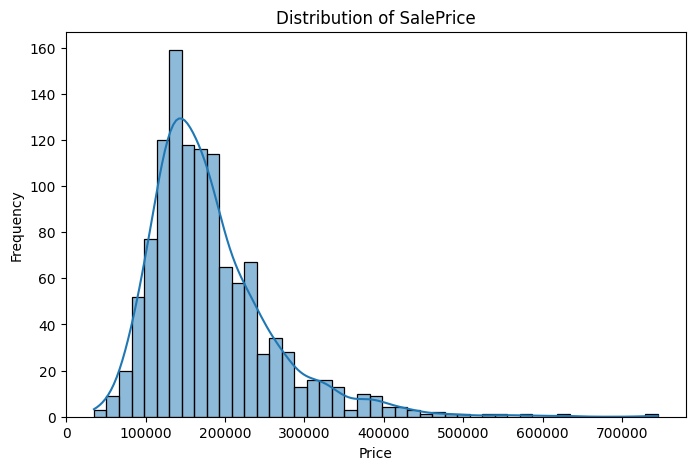

In [42]:
# Histogram of the target
plt.figure(figsize=(8, 5))
sns.histplot(y_train, kde=True)
plt.title('Distribution of SalePrice')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [43]:
# Check skewness
print(f"Target skewness: {y_train.skew():.2f}")

# If skewed > 0.75, consider log transformation
if y_train.skew() > 0.75:
    y_train_log = np.log1p(y_train)
    y_val_log = np.log1p(y_val)
    print("Applied log transformation to target")
else:
    y_train_log, y_val_log = y_train.copy(), y_val.copy()

Target skewness: 1.74
Applied log transformation to target


## checking numeric feature distributions. 
Highly skewed features can hurt linear models.we will use log transformation for skewed numeric features.

In [44]:
# Check skewness of all numeric features
numeric_features = X_train.select_dtypes(include=[np.number]).columns
skewness = X_train[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)

# Features with skewness > 0.75 (moderately skewed)
high_skew = skewness[abs(skewness) > 0.75]
print(f"Features with high skewness (>0.75): {len(high_skew)}")

# Apply log1p transformation to highly skewed features
for feature in high_skew.index:
    if X_train[feature].nunique() > 10:
        # Shift to positive values if needed
        min_val = X_train[feature].min()
        if min_val <= 0:
            shift = abs(min_val) + 1
            X_train[feature] = np.log1p(X_train[feature] + shift)
            X_val[feature] = np.log1p(X_val[feature] + shift)
            X_test[feature] = np.log1p(X_test[feature] + shift)
            print(f"Applied shifted log to: {feature} (min={min_val:.2f})")
        else:
            X_train[feature] = np.log1p(X_train[feature])
            X_val[feature] = np.log1p(X_val[feature])
            X_test[feature] = np.log1p(X_test[feature])
            print(f"Applied log to: {feature}")

Features with high skewness (>0.75): 168
Applied shifted log to: MiscVal (min=-0.09)
Applied shifted log to: LotArea (min=-0.87)
Applied shifted log to: 3SsnPorch (min=-0.12)
Applied shifted log to: LowQualFinSF (min=-0.12)
Applied shifted log to: BsmtFinSF2 (min=-0.29)
Applied shifted log to: ScreenPorch (min=-0.28)
Applied shifted log to: EnclosedPorch (min=-0.35)
Applied shifted log to: LotFrontage (min=-2.16)
Applied shifted log to: OpenPorchSF (min=-0.71)
Applied shifted log to: MasVnrArea (min=-0.60)
Applied shifted log to: BsmtFinSF1 (min=-0.97)
Applied shifted log to: TotalBsmtSF (min=-2.41)
Applied shifted log to: WoodDeckSF (min=-0.74)
Applied shifted log to: GrLivArea (min=-2.28)
Applied shifted log to: 1stFlrSF (min=-2.16)
Applied shifted log to: BsmtUnfSF (min=-1.28)
Applied shifted log to: 2ndFlrSF (min=-0.80)


## plotted distributions and skewness

We observe strong right skewness in features such as LotArea and GrLivArea, justifying the use of log transformation.

Plotting 20 features: ['Id', 'LotFrontage', 'LotArea', 'Street', 'Utilities', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF']


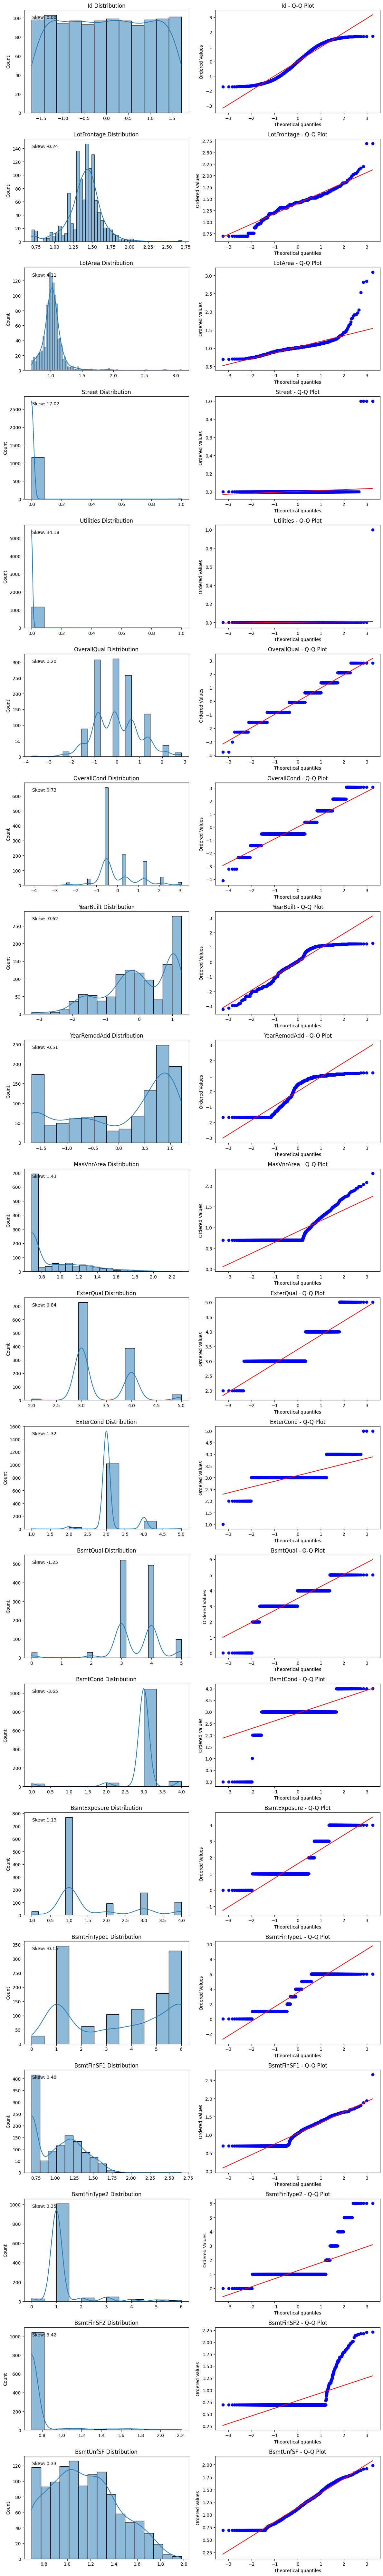

In [45]:
# Keep only up to 20 features to plot
existing_features = [f for f in numeric_features if f in X_train.columns][:20]
print(f"Plotting {len(existing_features)} features: {existing_features}")

fig, axes = plt.subplots(len(existing_features), 2, figsize=(12, 4*len(existing_features)))

for idx, feature in enumerate(existing_features):
    ax1, ax2 = axes[idx] if len(existing_features) > 1 else axes
    
    # Histogram
    sns.histplot(X_train[feature], ax=ax1, kde=True)
    ax1.set_title(f'{feature} Distribution')
    ax1.set_xlabel('')
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(X_train[feature].dropna(), dist="norm", plot=ax2)
    ax2.set_title(f'{feature} - Q-Q Plot')
    
    # Show skewness
    skew_after = X_train[feature].skew()
    ax1.text(0.05, 0.95, f'Skew: {skew_after:.2f}',
             transform=ax1.transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()


In [47]:
import pickle
import os

save_path = "pkl/prepared_data.pkl"


with open(save_path, "wb") as f:
    pickle.dump({
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_train_log': y_train_log,  # Log transformed target
        'y_val_log': y_val_log,
        'encoder': encoder,          # OneHotEncoder
        'scaler': scaler,            # StandardScaler
        'nominal_cols': nominal_cols, # Column names for reference
        'numerical_cols': numerical_cols,
        'ordinal_mappings': ordinal_mappings,
        'binary_cols': binary_cols
    }, f)

print(f"Saved to {save_path}")
print(f"File exists: {os.path.exists(save_path)}")
print(f"File size: {os.path.getsize(save_path) / 1024 / 1024:.2f} MB")

Saved to pkl/prepared_data.pkl
File exists: True
File size: 4.56 MB


In [288]:
# save_data = {
#     'X_train': X_train,
#     'X_val': X_val, 
#     'X_test': X_test,
#     'y_train': y_train,
#     'y_val': y_val,
#     'y_train_log': y_train_log,
#     'y_val_log': y_val_log,
#     'all_columns': X_train.columns.tolist()
# }

## Conclusion

In this notebook, we performed comprehensive data preparation for the House Prices regression task. The dataset was explored, cleaned, and transformed using statistically sound techniques, including skewness.

By saving the prepared data, we ensure a reproducible and modular workflow that supports fair and consistent model comparison. This preprocessing stage establishes a strong foundation for training advanced regression models.

In the next notebook, **`2-FeatureEngRegression.ipynb`**, we will focus on Feature Engineering using the prepared dataset.
